# **CT5133 Deep Learning - Assignment 2:**
## Unsupervised/self-supervised learning and generating images in Keras
**Submitted By:** Kalyani Prashant Kawale

**Student ID:** 21237189


## **Initial Setup**:

Setting dataset directory and loading libraries.

In [1]:
# Mounting the google drive to load dataset stored in the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setting the path to the directory containing dataset
%cd drive/MyDrive/Colab Notebooks/DeepLearning/Assignment2

/content/drive/MyDrive/Colab Notebooks/DeepLearning/Assignment2


In [3]:
# Loading required libraries
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import glob
import imageio
import PIL
import time
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.losses import mse
from keras import backend as K
from IPython import display

%matplotlib inline



---



## **Section 1: Data-Set**

* The data-set selected to train the unsupervised learning models to generate new images is **Devanagari Handwritten Character Dataset Data Set** [1, 2].
* Created to help benchmark classification algorithm for OCR systems, the data-set consists of 32x32 png images of handwritten devanagari characters, which is the alphabet for Indian langugaes like Hindi and Marathi [2].
* The data-set has been made available by [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) [3] and can be downloaded from  [Devanagari Handwritten Character Dataset](https://archive.ics.uci.edu/ml/datasets/Devanagari+Handwritten+Character+Dataset) [2].



### 1.1 Possible Application:

* Natural languages that use devanagari script are relatively under-resourced languages.
* However, as these are also widely spoken, images generated for the characters could be used in teaching applications such as Duolingo, to display the characters to help aid the learning process.
* While, character codes do exist for devanagari characters, the images generated on the go by an image generator could be much more useful in applications other than teaching tools as well, such as translation applications.

### 1.2 Dataset Loading and Preprocessing:

* The dataset [1], originally intended for use in classification tasks, has 92000 instances, distributed across number of labelled directories, thus, for the given task a smaller dataset has been created without the labels.
* 3 sizes of the smaller dataset with 720, 1430 and 18,000 instances respectively were created from the original dataset and used to train the models and the results were observed.
* In the following sections, training and results for dataset with 1430 instances have been displayed due to limited computing resources.
* OpenCV library has been used to read and preprocess the images.

> **Creating a list of image file names**:
> The *images* list is created to store the image file names, to be shuffled, and used to load the images according to the shuffled list.

In [45]:
# Saving image file names along with directory name in images list
path = './devanagari_letters'

images = [os.path.join(path, img) for img in os.listdir(path)]

In [46]:
# Shuffling the images list and setting seed for reproducibility
np.random.seed(200)
np.random.shuffle(images)

In [47]:
# Reading the png images from directory and resizing to 32x32,
# to ensure all images have same fixed size
img_array = []
for img in images:
  try:
    img_array.append(cv2.resize(cv2.imread(img), (32, 32)))
  except:
    # Skipping errorneous images 
    pass

> **Plotting first 9 images from the dataset in 3x3 grid:**

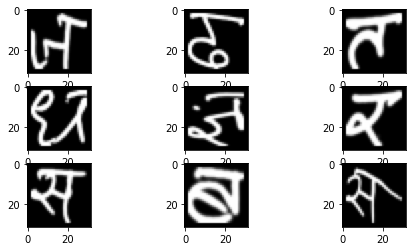

In [48]:
# Setting the plot size
fig = plt.figure(figsize=(8, 4))
# Specifying number of rows and columns,
# to show images in 3x3 grid
columns = 3
rows = 3
# Setting the position of images in the grid
for index, img in enumerate(img_array[0:9]):
  fig.add_subplot(rows, columns, index+1)
  plt.imshow(img)
# Displaying the images  
plt.show()

In [49]:
dataset = np.array(img_array)/255 # Normalizing image pixels between 0 to 1

In [50]:
dataset = tf.cast(dataset, tf.float32) # Converting the images into Tensorflow compatible format

In [51]:
dataset.shape

TensorShape([18000, 32, 32, 3])



---



## **Section 2: Building Auto-Encoder, Variational Auto-Encoder, and Generative Adversarial Network**

### 2.1 Network Architecture:

* For building comparative image generators using autoencoder (AE), variational autoencoder (VAE) and generative adversarial network (GAN), following common Keras layers has been configured for main computation in each model according to the model's design requirements:

  1. A 2D Convolutional layer with 16 filters and a 3x3 kernel, with stride set to 1.
  2. A 2D Convolutional layer with 32 filters and a 3x3 kernel, with stride set to 1.
  3. A 2D Convolutional layer with 64 filters and a 3x3 kernel, with stride set to 1.


* Each of the above layer used the Leaky Rectified Linear Unit activation function configured using Keras's LeakyReLU layer.

* Apart from these, Input, Dense, Flatten, Reshape layers and a custom Sampling layer are used to handle inputs, outputs and sampling from latent space.

* All the models use an Adam optimizer with 0.001 learning rate for training, and the training is ran for 20 epochs and 200 batch size.


### 2.2 Common Settings:

> **Initializing common settings**:

In [52]:
# Setting input and latent space dimensions
image_dim = (32, 32, 3)
latent_dim = 100
# Setting the epochs and batch size for model training
EPOCHS = 20
BATCH_SIZE = 200

> **Defining a common method for performing & displaying reconstructed images**: The autoencoder and variational autoencoder are trained primarily to generate their input as output, thus, a trained AE or VAE model can be used to reconstruct the input images using the model **predict** method as follows,

In [53]:
# Following code is based on plot_compare method taken from [9]
def reconstruct_results(generation_model, model, num_images=5, start=0):
  """
    Method to reconstruct input image using autoencoder
    params::generation_model: trained autoencoder or variational autoencoder
    params::model: name of the model
    params::num_images: number of images to be reconstructed
    params::start: start index of image in the dataset
  """
  # Sampling num_images number of images from the dataset
  sample_images = dataset[start:(start + num_images)]
  
  # Using the autoencoder/vae to reconstruct images using predict method
  reconstructed_imgs = generation_model.predict(sample_images)
  
  # Configuring figure to plot images
  img_len = len(sample_images)
  fig = plt.figure(figsize=(num_images + 3, 4))  

  # Configuring to plot the sampled dataset images
  for i in range(img_len):
    # Setting image position in plot
    sub = fig.add_subplot(2, img_len, i+1)
    sub.axis('off')
    sub.imshow(sample_images[i])

  # Configuring to plot the reconstructed images below the original images
  for i in range(img_len):
    # Setting image position in plot
    sub = fig.add_subplot(2, img_len, i+img_len+1)
    sub.axis('off')
    sub.imshow(reconstructed_imgs[i])
  # Saving the plot as png  
  plt.savefig(f'{model}_reconstruct_images.png')

> **Defining a common method to generate and display new samples**: The autoencoders are trained to generate output which is nothing but the input itself and the GAN trains its generator and discriminator to classify between fake and real images, during these trainings the decoder and the generator trained in the process become capable of creating new images from low-dimensional data. The following method is defined to use the **predict** method on decoder and/or generator to generate new sample images, which are then displayed in a 3x3 grid,

In [112]:
# Following plotting logic taken from [10]
def generate_images(img_generator, model, latent_dim, num_images=9, is_generator=True):
  """
    Method to generate new images
    params::img_generator: trained decoder or generator
    params::model: name of the model
    params::latent_dim: dimension of the latent space
    params::num_images: number of images to be reconstructed    
  """
  # Generating new images using img_generator, 
  # which is decoder in case of autoencoder and vae
  # and generator in case of GAN
  random_samples = np.random.normal(0, 1, size=(num_images, latent_dim))
  # Checking if the model is generator or decoder 
  # to apply appropriate generation method
  new_images = []
  if is_generator:    
    for i in range(9):
      noise = tf.random.normal([1, 100])
      new_images.append(img_generator(noise, training=False)[0, :, :, 0])
  else:
    new_images = img_generator.predict(random_samples)
  

  # Configuring figure plot to display images in 3x3 grid
  fig = plt.figure(figsize=(10, 5))
  columns = 3
  rows = 3
  for i in range(columns*rows):
    # Setting the position of image in the grid
    fig.add_subplot(rows, columns, i+1)
    # Adding generated image to plot 
    if is_generator:
      plt.imshow((255 * new_images[i]))
    else:  
      plt.imshow((255 * new_images[i]).astype(np.uint8))
  
  # Saving and displaying the 3x3 grid with all generated images
  plt.savefig(f'{model}_images.png')
  plt.show()

### 2.3 Auto-Encoder:

* An autoencoder presents a neural network approach to dimensionality reduction [14]. 
* It consists of two parts, an encoder which compresses the input into smaller dimensional vector (latent space) and a decoder which reconstructs the input using data from latent space. 
* Based on the network architecture described in section 2.1, the encoder and decoder for the given task have been configured using Keras **Sequential** model and the autoencoder is created by combining these individual models.

The implementation, training and results of the autoencoder are as follows,

> **Defining build method for autoencoder, specifying the network architecture**:

In [97]:
# Following code is a modified version of code taken from [8]
def build_autoencoder(image_dim, latent_dim):
    """
    Method to build autoencoder with Keras layers
    params::image_dim: input image dimension
    params::latent_dim: latent space dimension
    """
    # Adding layers to encoder model
    encoder = Sequential()
    # Taking input of dimension (32, 32, 3) where,
    # height = 32, width = 32, color channels = 3
    encoder.add(InputLayer(image_dim))
    encoder.add(Conv2D(filters=16, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    encoder.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    encoder.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    encoder.add(Flatten())
    # Outputting the latent space using Dense layer
    encoder.add(Dense(latent_dim))

    # Adding layers to decoder model
    decoder = Sequential()
    # Taking input from latent space
    decoder.add(InputLayer((latent_dim,)))
    # Setting Dense layer with 32 * 32 * 3 neurons
    decoder.add(Dense(np.prod(image_dim)))
    decoder.add(Reshape(image_dim))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    decoder.add(Conv2DTranspose(filters=16, kernel_size=(3,3), padding='same'))
    encoder.add(LeakyReLU())
    decoder.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), padding='same', 
                                activation='sigmoid'))
    
    # Configuring the Auto-Encoder
    original_inputs = Input(image_dim, name="encoder_input")
    encode = encoder(original_inputs)
    reconstruction = decoder(encode)
    autoencoder = Model(original_inputs, reconstruction)

    return autoencoder, encoder, decoder


> **Building and compiling the autoencoder**:

In [98]:
# Getting the models
autoencoder, encoder, decoder = build_autoencoder(image_dim, latent_dim)
# Setting the optimizer
optimizer = keras.optimizers.Adam(1e-3)
# Compiling the auto-encoder
autoencoder.compile(optimizer=optimizer, loss='mse')

> **Printing model summaries:**

In [99]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 3)]       0         
                                                                 
 sequential_4 (Sequential)   (None, 100)               6577284   
                                                                 
 sequential_5 (Sequential)   (None, 32, 32, 3)         335587    
                                                                 
Total params: 6,912,871
Trainable params: 6,912,871
Non-trainable params: 0
_________________________________________________________________


In [100]:
encoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 65536)            

In [101]:
decoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 3072)              310272    
                                                                 
 reshape_2 (Reshape)         (None, 32, 32, 3)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 32, 32, 64)       1792      
 ranspose)                                                       
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 32, 32, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 32, 32, 16)       4624      
 Transpose)                                                      
                                                      

> **Training the autoencoder with Devanagari Handwritten Character dataset**:

In [102]:
# Training model and saving the returned History object in history
history = autoencoder.fit(x=dataset, y=dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
90/90 [==============================] - 220s 2s/step - loss: 0.0599
Epoch 2/20
90/90 [==============================] - 218s 2s/step - loss: 0.0152
Epoch 3/20
90/90 [==============================] - 219s 2s/step - loss: 0.0106
Epoch 4/20
90/90 [==============================] - 218s 2s/step - loss: 0.0086
Epoch 5/20
90/90 [==============================] - 218s 2s/step - loss: 0.0076
Epoch 6/20
90/90 [==============================] - 219s 2s/step - loss: 0.0070
Epoch 7/20
90/90 [==============================] - 219s 2s/step - loss: 0.0066
Epoch 8/20
90/90 [==============================] - 221s 2s/step - loss: 0.0063
Epoch 9/20
90/90 [==============================] - 220s 2s/step - loss: 0.0060
Epoch 10/20
90/90 [==============================] - 223s 2s/step - loss: 0.0059
Epoch 11/20
90/90 [==============================] - 219s 2s/step - loss: 0.0058
Epoch 12/20
90/90 [==============================] - 216s 2s/step - loss: 0.0056
Epoch 13/20
90/90 [==================

> **Plotting the learning curve for autoencoder**:



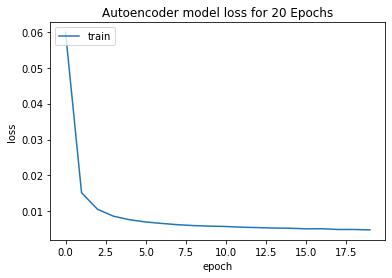

In [104]:
# Plotting the loss fetched from the History object returned by fit method
plt.plot(history.history['loss'])
plt.title('Autoencoder model loss for 20 Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

> **Checking the reconstruction of images performed by autoencoder**:

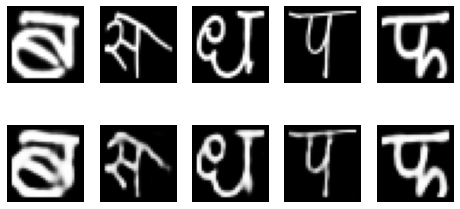

In [105]:
reconstruct_results(autoencoder, 'autoencoder', num_images=5, start=7)

> **Generating new samples using autoencoder**:

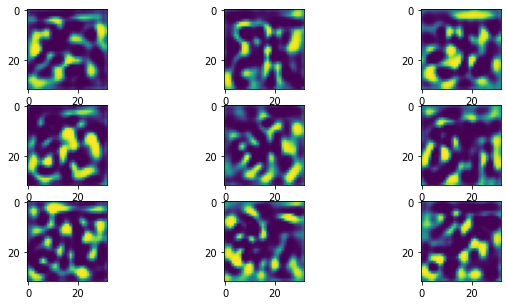

In [113]:
# Generating 9 samples using autoencoder's decoder
generate_images(decoder, 'autoencoder', latent_dim)

### 2.4 Variational Auto-Encoder:

* Autoencoders, like any other ML algorithms are prone to overfitting, which makes it difficult to use autoencoders for generating new data [14, 17].

* Variational autoencoder introduces regularisation of the loss function to help solve this problem, by ensuring regularity of the latent space.

* For this purpose the input is encoded into a distribution to provide disentagled dimensions (each dimension with a meaning associated with it) from which the latent space is sampled and given input to the decoder [17]. A custom layer called Sampling [7] is used in the network architecture to provide the said distribution.

* The Kullback-Leibler loss is used and added as the loss metric to the vae model for loss regularisation.

The implementation, training and results of the variational autoencoder are as follows,


> **Defining Sampling layer to be used by variational autoencoder**:

In [114]:
# Following code is taken from [7]
# Custom sampling layer used to get the latent space
class Sampling(keras.layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
  def call(self, inputs):
    # override the inherited .call(self, inputs) method
    z_mean, z_log_var = inputs
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean)) # N(0, 1)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon # N(mu, sigma)

> **Defining build method for variational autoencoder specifying the network architecture**:

In [115]:
# Following code is a modified version of code taken from [7]
def build_vae(image_dim, latent_dim):
  """
    Method to build variational autoencoder with Keras layers
    params::image_dim: input image dimension
    params::latent_dim: latent space dimension
  """
  # Adding layers to Encoder model
  original_inputs = Input(shape=(image_dim), name="encoder_input")
  x = Conv2D(filters=16, kernel_size=(3,3), padding='same')(original_inputs)
  x = LeakyReLU()(x)
  x = Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  x = Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  x = Flatten()(x)
  z_mean = Dense(latent_dim, name="z_mean")(x)
  z_log_var = Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()((z_mean, z_log_var))
  vae_encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

  # Adding layers to Decoder model
  latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
  x = Dense(np.prod(image_dim))(latent_inputs)
  x = Reshape(image_dim)(x)
  x = Conv2DTranspose(filters=64, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  x = Conv2DTranspose(filters=32, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  x = Conv2DTranspose(filters=16, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU()(x)
  outputs = Conv2DTranspose(filters=3, kernel_size=(3, 3), padding='same', activation='sigmoid')(x)  
  vae_decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")    

  # Defining VAE model
  outputs = vae_decoder(z)
  vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

  # Loss approach from
  # https://gist.github.com/tik0/6aa42cabb9cf9e21567c3deb309107b7  
  reconstruction_loss = mse(original_inputs, outputs)
  # taking product of the image dimension tuple to get a single dimension
  reconstruction_loss = np.prod(image_dim) * K.mean(reconstruction_loss)
  kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

  # Setting up reconstruction and Kullback-Leibler regularisation losses on the model, 
  # and adding them as metrics for the model.
  # The Model's loss is the sum of the two losses.
  vae.add_loss(kl_loss)
  vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
  vae.add_loss(reconstruction_loss)
  vae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

  return vae, vae_encoder, vae_decoder

> **Building and compiling the variational autoencoder**:

In [116]:
# Getting the models
vae, vae_encoder, vae_decoder = build_vae(image_dim, latent_dim)
# Setting the optimizer
vae_optimizer = keras.optimizers.Adam(1e-3)
# Compiling the variational autoencoder model
vae.compile(optimizer=vae_optimizer)

> **Printing model summaries**:

In [117]:
vae_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 16)   448         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 32, 32, 16)   0           ['conv2d_9[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 32)   4640        ['leaky_re_lu_18[0][0]']         
                                                                                            

In [118]:
vae_decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 100)]             0         
                                                                 
 dense_6 (Dense)             (None, 3072)              310272    
                                                                 
 reshape_3 (Reshape)         (None, 32, 32, 3)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 32, 32, 64)       1792      
 Transpose)                                                      
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 32, 32, 32)       18464     
 Transpose)                                                

> **Training the variational autoencoder with Devanagari Handwritten Character dataset**:

In [119]:
# Training model and saving the returned History object in history
vae_history = vae.fit(x=dataset, y=dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
90/90 [==============================] - 254s 3s/step - loss: 191.0322 - kl_loss: 5.0754 - mse_loss: 185.9568
Epoch 2/20
90/90 [==============================] - 255s 3s/step - loss: 37.2615 - kl_loss: 3.5242 - mse_loss: 33.7373
Epoch 3/20
90/90 [==============================] - 255s 3s/step - loss: 23.5312 - kl_loss: 3.2603 - mse_loss: 20.2709
Epoch 4/20
90/90 [==============================] - 255s 3s/step - loss: 19.5689 - kl_loss: 3.2025 - mse_loss: 16.3664
Epoch 5/20
90/90 [==============================] - 256s 3s/step - loss: 17.6105 - kl_loss: 3.1818 - mse_loss: 14.4287
Epoch 6/20
90/90 [==============================] - 255s 3s/step - loss: 16.7055 - kl_loss: 3.1712 - mse_loss: 13.5343
Epoch 7/20
90/90 [==============================] - 255s 3s/step - loss: 15.7555 - kl_loss: 3.1677 - mse_loss: 12.5878
Epoch 8/20
90/90 [==============================] - 256s 3s/step - loss: 15.2723 - kl_loss: 3.1599 - mse_loss: 12.1123
Epoch 9/20
90/90 [============================

> **Plotting the learning curve for variational autoencoder**:

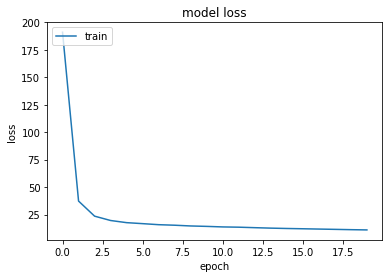

In [125]:
# Plotting the loss fetched from the History object returned by fit method
plt.plot(vae_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

> **Checking the reconstruction of images performed by variational autoencoder**:

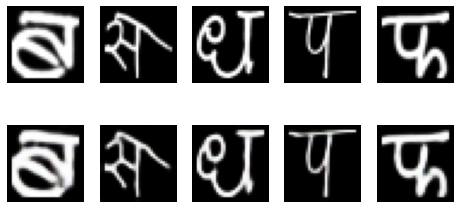

In [126]:
reconstruct_results(vae, 'vae', num_images=5, start=7)

> **Generating new samples using variational autoencoder**:

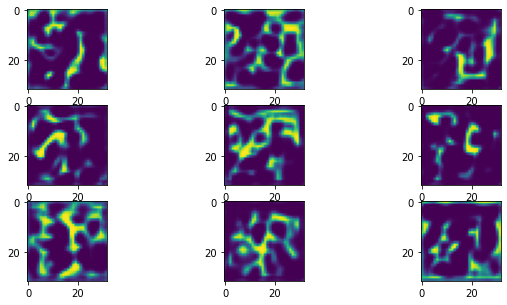

In [127]:
# Generating 9 samples using variational autoencoder's decoder
generate_images(vae_decoder, 'vae', latent_dim)

### 2.5 Generative Adversarial Network:

* Generative Adversarial Networks based on Game Theory principles, consists of two models, an generator and discriminator which are trained together in an adversarial fashion.
* The generator is trained to generate fake images from latent space and the discriminator is trained to classify the images generated by generator as fake. 
* The optimisation objective for both the models is competitive which enforces both the models to achieve an equilibrium while training.
* Keras layers and a custom training function using Tensorflow's Gradient Tape have been implemented to design and train the GAN for this task.
 
The implementation, training and results of the Generative Adversarial Network are as follows,

> **Designing the generator architecture**:

In [13]:
# Code based on tutorial given in [13]
def make_generator_model(image_dim, latent_dim):
    """
    Method to build generator with Keras layers
    params::image_dim: input image dimension
    params::latent_dim: latent space dimension
    """
    # Adding layers to the generator similar to the decoders in section 2.3 and 2.4
    G = Sequential()
    G.add(InputLayer((latent_dim,)))
    G.add(Dense(np.prod(image_dim), use_bias=False))
    G.add(Reshape(image_dim))
    G.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same'))
    G.add(LeakyReLU())
    G.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), padding='same'))
    G.add(LeakyReLU())
    G.add(Conv2DTranspose(filters=16, kernel_size=(3, 3), padding='same'))
    G.add(LeakyReLU())
    G.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), padding='same', activation='sigmoid'))
    return G

> **Initializing the generator model and checking random image generation**:

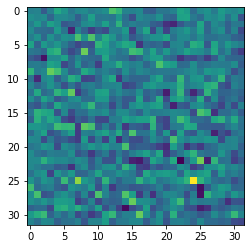

In [14]:
# Code from on tutorial given in [13]

# Getting the generator model
generator = make_generator_model(image_dim, latent_dim)
# Creating a sample image of latent_dim with random values
noise = tf.random.normal([1, 100])
# Using the generator to create image from the low dimensional vector
generated_image = generator(noise, training=False)
# Displaying the generated image
plt.imshow(generated_image[0, :, :, 0])

> **Designing discriminator architecture**:

In [15]:
# Code based on tutorial given in [13]

def make_discriminator_model(image_dim, latent_dim):
    """
      Method to build discriminator with Keras layers
      params::image_dim: input image dimension
      params::latent_dim: latent space dimension
    """
    # Adding layers to the discriminator similar to the encoders in section 2.3 and 2.4
    D = Sequential()
    D.add(InputLayer(image_dim))
    D.add(Conv2D(filters=16, kernel_size=(3,3), padding='same'))
    D.add(LeakyReLU())
    D.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
    D.add(LeakyReLU())
    D.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
    D.add(LeakyReLU())
    D.add(Flatten())
    D.add(Dense(1))

    return D

> **Using the discriminator model to identify if the image generated by the generator is real or fake**:


In [16]:
# Code from tutorial given in [13]

# Getting the discriminator
discriminator = make_discriminator_model(image_dim, latent_dim)
# Classifying the random sample generated by generator into real or fake image
decision = discriminator(generated_image) # negative output for fake and positive output for real
print(decision)

tf.Tensor([[-0.11753118]], shape=(1, 1), dtype=float32)


> **Printing generator and decoder model summaries:**

In [81]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3072)              307200    
                                                                 
 reshape (Reshape)           (None, 32, 32, 3)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       1792      
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 32)       18464     
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0

In [82]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 flatten (Flatten)           (None, 65536)            

It can be seen from above result that the image generated without training is classified by the discriminator as a fake image.

> **Defining the losses for both generator and discriminator**: The GAN is designed as a classifier to distinguish fake images from real, hence binary cross-entropy loss is used as the loss function in training.

In [17]:
# Code from tutorial given in [13]

# Using the Keras BinaryCrossentropy function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Setting loss for discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
# Setting loss for generator
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


> **Setting optimizers for generator and discriminator**:

In [18]:
# Code based on tutorial given in [13]

# Setting the optimizers same as section 2.3 and 2.4
generator_optimizer = keras.optimizers.Adam(1e-3)
discriminator_optimizer = keras.optimizers.Adam(1e-3)

In [19]:
# Code from tutorial given in [13]

# Saving checkpoints to enable retrieval of training in case of runtime errors
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

> **Defining the GAN training methods**:

In [55]:
# Code based on tutorial given in [13]

# Samples to be generated while training
num_examples_to_generate = 9

# Creating random samples to check training progress
seed = tf.random.normal([num_examples_to_generate, latent_dim])

In [56]:
# Code from tutorial given in [13]

# Using `tf.function` for compiling the train_step method.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
# Code from tutorial given in [13]
def train(dataset, epochs):
  # For each epoch training batch size images
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)
    # Producing images for the GIF to show generator progress
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    # Saving the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [23]:
# Code based on tutorial given in [13]

def generate_and_save_images(model, epoch, test_input):
  # `training` set to False to run all layers in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  
  # Configuring the plot to display generated images in 3x3 grid
  fig = plt.figure(figsize=(8, 4))
  for i in range(predictions.shape[0]):
    # Setting image position
    plt.subplot(3, 3, i+1)
    plt.imshow(predictions[i, :, :, 0] * 255)
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

> **Dataset preparation for training GAN with Devanagari Handwritten Character dataset**:

In [57]:
# Setting the buffer size to length of dataset to ensure 
# all samples are used when shuffling is performed
BUFFER_SIZE = len(dataset)

In [58]:
# Batching and shuffling the data using the common batch size 
# and shuffling with entire data-set
gan_train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

> **Training the deep convolutional GAN with Devanagari Handwritten Character dataset**:

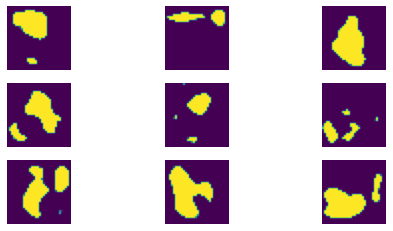

In [59]:
GAN_EPOCHS = 20
train(gan_train_dataset, GAN_EPOCHS)

In [60]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

> **Displaying images generated by GAN during training as a GIF**:

In [62]:
# Code from tutorial given in [13]
anim_file = 'dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
# Uncomment and install to view the GIF as embedded image
# !pip install git+https://github.com/tensorflow/docs


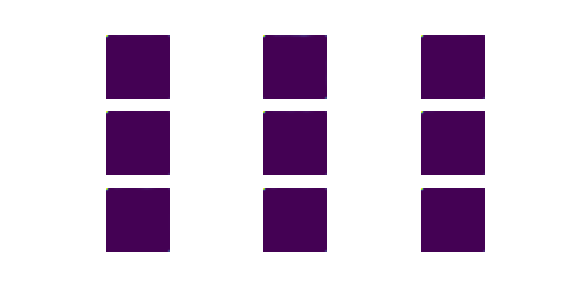

In [63]:
# Code from tutorial given in [13]
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

> **Generating new samples using the trained generator of deep convolutional GAN**:


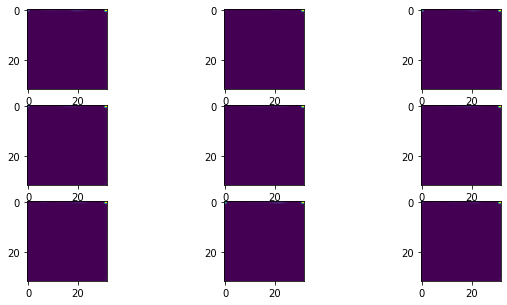

In [96]:
# Generating 9 samples using GAN's generator
generate_images(generator, 'gan', latent_dim, is_generator=True)



---



## **Section 3: Results**

### 3.1 Auto-Encoder:

> **Image reconstruction results achieved by the trained Autoencoder:**

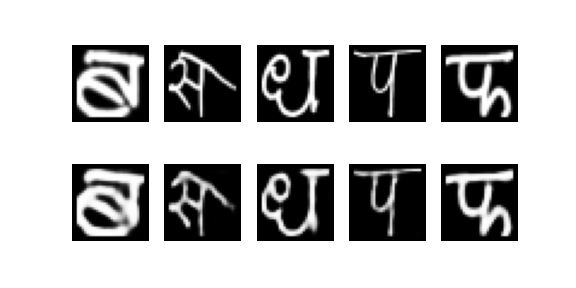


* From the above result it can be seen that the autoencoder trained with 18000 images has been able to reconstruct the images of the characters exactly the same as the original image, with some tiny pixel differences.
* The same autoencoder had also generated nearly same images even with smaller dataset of 1430 images, while the images were more fuzzy when only 720 instances were trained.
* The drop in loss has also been consistent as can be seen from the learning curve plotted in section 2.3 above.

> **9 new samples generated by the decoder of the trained autoencoder:**

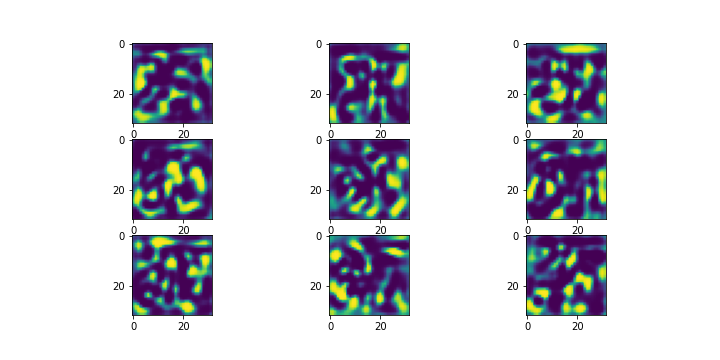


* It can be seen that even though the input images only had black and white colored pixels, after learning from 18,000 images the autoencoder has been able to generate images with different colors.
* When trained with smaller datasets however, the autoencoder was generating noise images with white blobs on black background.
* While most images display noise, some of the patterns in the generated images represent a consonant used in marathi language which was not even a part of the dataset, example, the fourth image has a pattern similar to 
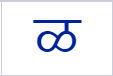, image taken from [19]


### 3.2 Variational Autoencoder:

> **Image reconstruction results achieved by the trained VAE:**

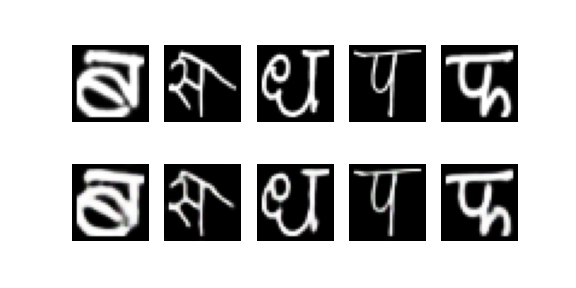
* Similar to the results of the autoencoder the VAE reconstruction also produces similar images with even more refined pixels closer to the original image than the auto-encoder.

* The loss can be seen to drop consistently for VAE training as well, as seen from the learning curve plotted in section 2.4.

> **9 new samples generated by the decoder of the trained VAE:**

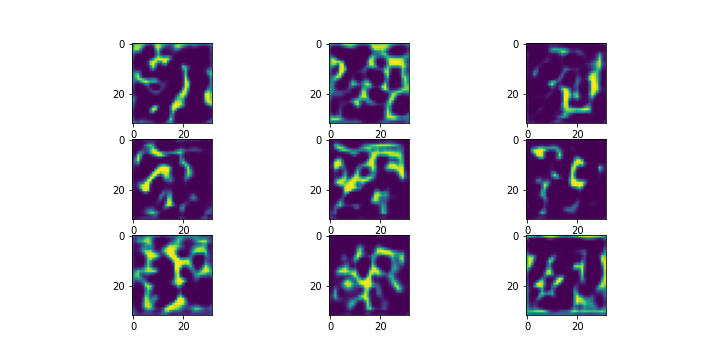
* The trained VAE also generates colored images after training with 18,000 images, which was giving results similar to autoencoder when less images were used for training.

* It can be seen from above image that the VAE is able to generate finer edges and patterns compared to the autoencoder, and with more training maybe able to generate better, more meaningful colored character images.

### 3.3 Generative Adversarial Network:


> **Images generated by GAN generator after First Epoch:**


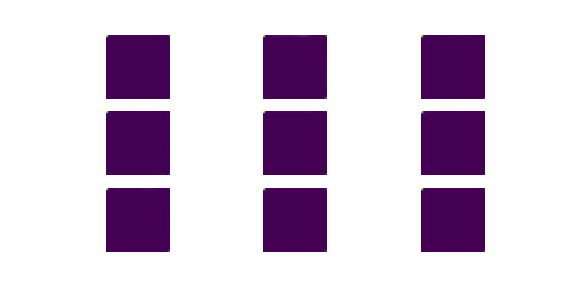

> **Images generated by GAN generator after Last Epoch:**

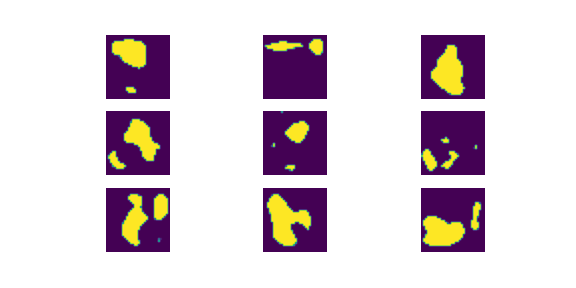

* From the above two plots it can be seen that during training, GAN starts generating colored images right from the first epoch, however it was observed that it kept generating similar indigo colored squares until the 18th epoch and it was only at the last two epochs that the yellow colored blobs started appearing in the image.

* It was also found that with smaller datasets of the images the GAN only generated black or indigo colored pixels for entire image, where the autoencoders had been able to generate some patterns similar to the input images.


> **9 new samples generated by the generator of the trained GAN:**

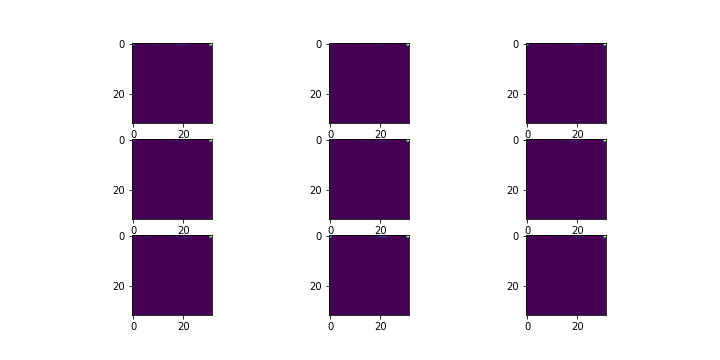


* Images generated by GAN using random noise after training is complete, are mostly indigo colored squares, which could be due to either insufficient data for training, insufficient number of epochs or the architecture designed chosen for models may not have been suitable for GAN, for the used dataset.



---



## References & Acknowledgements:

**Following resources were referred to perform the given tasks**,

[1] S. Acharya, A.K. Pant and P.K. Gyawali. Deep Learning Based Large Scale Handwritten Devanagari Character Recognition, In Proceedings of the 9th International Conference on Software, Knowledge, Information Management and Applications (SKIMA), pp. 121-126, 2015.

[2] Devanagari Handwritten Character Dataset Data Set. https://archive.ics.uci.edu/ml/datasets/Devanagari+Handwritten+Character+Dataset

[3] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

[4] Dr. M. Madden. (2021). Load and View CIFAR-10 Data.

[5] Dr. I. Ullah. (2022). ImageProcessing_CV.

[6] Dr. J. McDermott. (2022). Week 7 Lecture Material. Source Code: keras_mnist.py

[7] Dr. J. McDermott. (2022). Week 8 Lecture Material. Source Code: vae.py

[8] Ali Abdelaal. Autoencoders for Image Reconstruction in Python and Keras. Available at: https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/

[9] Dhanush Kamath. (2020). Generating New Faces With Variational Autoencoders. Available at: https://www.topbots.com/generating-new-faces-with-variational-autoencoders/

[10] How to display multiple images in one figure correctly? [duplicate]. (2021). Available at: https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645

[11] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). (2021). Available at: https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa

[12] Muhammad Ardi. (2020). Using Variational Autoencoder (VAE) to Generate New Images. Available at: https://becominghuman.ai/using-variational-autoencoder-vae-to-generate-new-images-14328877e88d

[13] Deep Convolutional Generative Adversarial Network. Available at: https://www.tensorflow.org/tutorials/generative/dcgan

[14] Understanding Variational Autoencoders (VAEs). Available at: https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

[15] Dr. J. McDermott. (2022). Week 07-01: Deep Learning Libraries
Introduction.

[16] Dr. J. McDermott. (2022). Week 07-02: Deep Learning Libraries
A First Keras Model.

[17] Dr. J. McDermott. (2022). Week 08: Auto-encoders.

[18] Dr. J. McDermott. (2022). Week 09: Generative Adversarial Networks.

[19] Devanagari Script Unicode Entity Codes. Available at: https://sites.psu.edu/symbolcodes/languages/southasia/devanagari/devanagarichart/